# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

## Описание данных

**Признаки**

- DateCrawled — дата скачивания анкеты из базы

- VehicleType — тип автомобильного кузова

- RegistrationYear — год регистрации автомобиля

- Gearbox — тип коробки передач

- Power — мощность (л. с.)

- Model — модель автомобиля

- Kilometer — пробег (км)

- RegistrationMonth — месяц регистрации автомобиля

- FuelType — тип топлива

- Brand — марка автомобиля

- NotRepaired — была машина в ремонте или нет

- DateCreated — дата создания анкеты

- NumberOfPictures — количество фотографий автомобиля

- PostalCode — почтовый индекс владельца анкеты (пользователя)

- LastSeen — дата последней активности пользователя


**Целевой признак**

 - Price — цена (евро)

## Подготовка данных

**Подгрузим библиотеки**

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import time
import matplotlib.pyplot as plt
from numpy.random import RandomState
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from catboost import Pool, CatBoostRegressor
import lightgbm as lgb
from sklearn.preprocessing import StandardScaler, LabelEncoder, OrdinalEncoder

**Загрузим датасет**

In [3]:
data = pd.read_csv('/datasets/autos.csv')

**Посмотрим общую информацию о наборе данных**

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  NotRepaired        283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

**Итог:**

 - **В данных есть пропуски**
 
 
 - **Тип данных клонок с датой необходимо изменить с object на  datetime**
 
 
 - **Названия колонок не соответствую стандарту snake_case**

**Посмотрим на содержимое датасета**

In [5]:
data.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


**Переведу регистр названия колонок в нижний для удобства**

In [6]:
data.columns = data.columns.str.lower()

**Теперь изменю тип данных колонок с датой на datetime**

In [7]:
data['datecrawled'] = pd.to_datetime(data['datecrawled'], format='%Y-%m-%d %H:%M:%S')
data['datecreated'] = pd.to_datetime(data['datecreated'], format='%Y-%m-%d %H:%M:%S')
data['lastseen'] = pd.to_datetime(data['lastseen'], format='%Y-%m-%d %H:%M:%S')

**Скорректируем названия колонок по стандарту snake_case**

In [8]:
data = data.rename(columns={'datecrawled': 'date_crawled',
                            'vehicletype': 'vehicle_type',
                            'registrationyear': 'registration_year',
                            'registrationmonth': 'registration_month',
                            'fueltype': 'fuel_type',
                            'notrepaired': 'not_repaired',
                            'datecreated': 'date_created',
                            'numberofpictures': 'number_of_pictures',
                            'postalcode': 'postal_code',
                            'lastseen': 'last_seen'})

**Посмотрим количество явных дубликатов, и удалим их, если они есть.**

In [9]:
print('Количество явных дубликтов -',data.duplicated().sum())
data = data.drop_duplicates().reset_index(drop=True)
print('Количество явных дубликтов после удаления -',data.duplicated().sum())

Количество явных дубликтов - 4
Количество явных дубликтов после удаления - 0


**Посмотрим на значения в колонке registration_year**

In [10]:
print(np.sort(data['registration_year'].unique()))

[1000 1001 1039 1111 1200 1234 1253 1255 1300 1400 1500 1600 1602 1688
 1800 1910 1915 1919 1920 1923 1925 1927 1928 1929 1930 1931 1932 1933
 1934 1935 1936 1937 1938 1940 1941 1942 1943 1944 1945 1946 1947 1948
 1949 1950 1951 1952 1953 1954 1955 1956 1957 1958 1959 1960 1961 1962
 1963 1964 1965 1966 1967 1968 1969 1970 1971 1972 1973 1974 1975 1976
 1977 1978 1979 1980 1981 1982 1983 1984 1985 1986 1987 1988 1989 1990
 1991 1992 1993 1994 1995 1996 1997 1998 1999 2000 2001 2002 2003 2004
 2005 2006 2007 2008 2009 2010 2011 2012 2013 2014 2015 2016 2017 2018
 2019 2066 2200 2222 2290 2500 2800 2900 3000 3200 3500 3700 3800 4000
 4100 4500 4800 5000 5300 5555 5600 5900 5911 6000 6500 7000 7100 7500
 7800 8000 8200 8455 8500 8888 9000 9229 9450 9996 9999]


**Посмотрим на диаграмму размаха для значений "Год регистрации"**

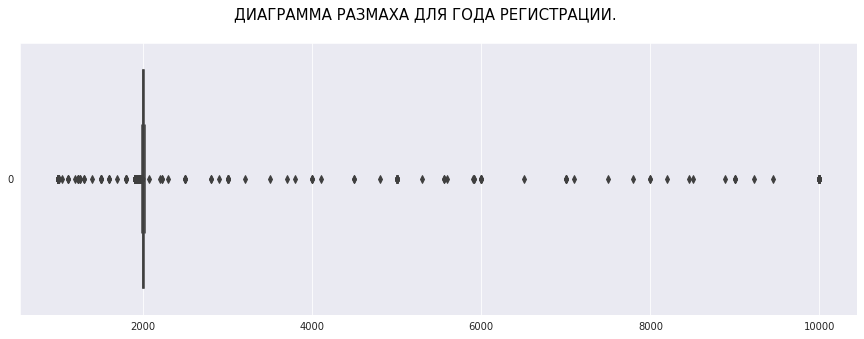

In [11]:
plt.figure(figsize=[15, 5])
plt.suptitle('ДИАГРАММА РАЗМАХА ДЛЯ ГОДА РЕГИСТРАЦИИ.', fontsize=15)
sns.set_style('darkgrid')
sns.boxplot(data=data['registration_year'], orient='h');

**В значениях присутствуют аномальные даты. Что бы определить актуальный период посмотрим на дату скачивания анкеты.**

In [20]:
list(data['date_crawled'].dt.year.unique())

[2016]

In [21]:
print('Количество аномальных значений в дате регистрации автомобиля -', len(data[(data['registration_year'] <= 1985) | (data['registration_year'] >= 2016)]))

Количество аномальных значений в дате регистрации автомобиля - 30333


In [22]:
print('Соотношение аномальных значений к размер датасета составляет - %.2f' % (len(data[(data['registration_year'] <= 1985) | (data['registration_year'] >= 2016)])/ data.shape[0] * 100))

Соотношение аномальных значений к размер датасета составляет - 8.56


**Так как процент удаляемых значений не велик, избавимся от них.**

In [24]:
data = (data[(data['registration_year'] >= 1985) & (data['registration_year'] <= 2016)])

In [25]:
np.sort(data['registration_year'].unique())

array([1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994, 1995,
       1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006,
       2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016])

**Посмотрим на значения в колонке power**

In [26]:
print(np.sort(data['power'].unique()))

[    0     1     2     3     4     5     6     7     8     9    10    11
    12    13    14    15    16    17    18    19    20    21    22    23
    24    25    26    27    28    29    30    31    32    33    34    35
    36    37    38    39    40    41    42    43    44    45    46    47
    48    49    50    51    52    53    54    55    56    57    58    59
    60    61    62    63    64    65    66    67    68    69    70    71
    72    73    74    75    76    77    78    79    80    81    82    83
    84    85    86    87    88    89    90    91    92    93    94    95
    96    97    98    99   100   101   102   103   104   105   106   107
   108   109   110   111   112   113   114   115   116   117   118   119
   120   121   122   123   124   125   126   127   128   129   130   131
   132   133   134   135   136   137   138   139   140   141   142   143
   144   145   146   147   148   149   150   151   152   153   154   155
   156   157   158   159   160   161   162   163   

**В колонке присутствуют аномальные значения (0 и значения > 400). От значениий больше 400 избавимся ( для легковой машины значения больше аномальны), а значения равные 0, заменим медианным значением мощности по брендам.**

In [27]:
print('Количество аномальных значений в колонке "Мощность мотора" -', len(data[(data['power'] >= 400)]))

Количество аномальных значений в колонке "Мощность мотора" - 730


In [28]:
data = data[data['power'] <= 400]

In [29]:
dict_with_medians_power = data.groupby('brand')['power'].median().to_dict()

In [30]:
def replacing_zeros(row):
    power = row['power']
    brand = row['brand']
    if power == 0:
        power = int(dict_with_medians_power[brand])
    return power


data.loc[(data['power'] == 0) , 'power'] = data.apply(replacing_zeros, axis=1)       

**Посмотрим на значения в колонке registration_month**

In [31]:
data['registration_month'].unique()

array([ 0,  5,  8,  6,  7, 10, 12, 11,  2,  3,  1,  4,  9])

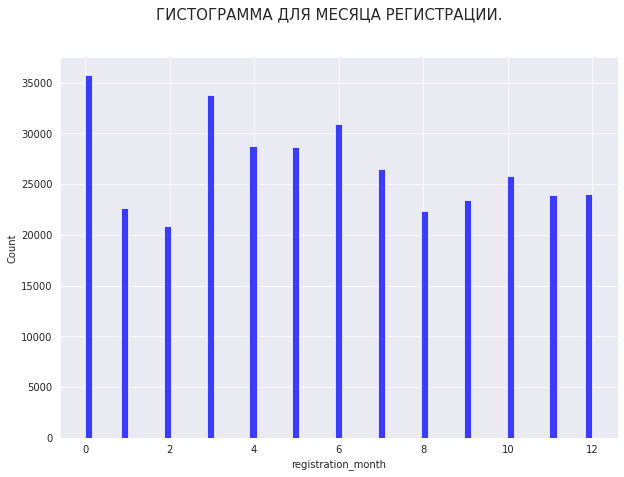

In [24]:
plt.figure(figsize=[10, 7])
plt.suptitle('ГИСТОГРАММА ДЛЯ МЕСЯЦА РЕГИСТРАЦИИ.', fontsize=15)
sns.set_style('darkgrid')
sns.histplot(data=data['registration_month'], color='b', kde=False);

**В данных значение 0 может означать первый месяц,если использовался диапазон от 0-11, либо могли использовать диапазон от 1-12, тогда 0 - обозначает может значить, что месяц регистрации не известен( возможно так же, что данные были утеряна при выгрузке). Предлагаю оставить как есть.**

**Посмотрим зна значения в колонке price**

In [32]:
print(np.sort(data['price'].unique()))

[    0     1     2 ... 19998 19999 20000]


**Обнаружена цены с нулевым значением**

In [33]:
print('Количество строк , для которых цена равна 0 -', len(data[data['price'] == 0]))
print('Соотношение кол-ва сток с нулевой ценой к общему размеру - ', (len(data[data['price'] == 0]) / data.shape[0]) * 100)

Количество строк , для которых цена равна 0 - 9530
Соотношение кол-ва сток с нулевой ценой к общему размеру -  2.855807207541968


**Кол-во строк с пропусками не велико по отношению ко всему размеру датасета, поэтому избавимся от таких строк.**

In [34]:
data = data.query('price != 0')

**Посмотрим на значения в колонке fuel_type**

In [35]:
data['fuel_type'].unique()

array(['petrol', 'gasoline', nan, 'lpg', 'other', 'hybrid', 'cng',
       'electric'], dtype=object)

In [36]:
print('Количество строк с NAN в типе двигателя -', len(data[data['fuel_type'].isna()]))

Количество строк с NAN в типе двигателя - 23234


**И petrol и gasoline подразумевают бензин, поэтому заменим gasoline на petrol. Пропуски заменим  часто повторяющимся значением основанным на группировке по бренду.**

In [37]:
data['fuel_type'] = data['fuel_type'].replace('gasoline', 'petrol')

In [38]:
data['fuel_type'] = data.groupby(['brand'])['fuel_type'].transform(lambda x: x.fillna((x.mode()[0] if not x.mode().empty else 'other')))

In [39]:
data['fuel_type'].unique()

array(['petrol', 'lpg', 'other', 'hybrid', 'cng', 'electric'],
      dtype=object)

In [40]:
print('Кол-во строк со значением fuel_type равное other -', len(data[data['fuel_type'] == 'other']))

Кол-во строк со значением fuel_type равное other - 128


**Количество строк не велико.Предлагаю убрать такие строки из датасета**

In [41]:
data = data[data['fuel_type'] != 'other']

**Посмотрим на колонку brand**

In [42]:
data['brand'].unique()

array(['volkswagen', 'audi', 'jeep', 'skoda', 'bmw', 'peugeot', 'ford',
       'mazda', 'nissan', 'renault', 'mercedes_benz', 'seat', 'honda',
       'fiat', 'opel', 'mini', 'smart', 'hyundai', 'sonstige_autos',
       'alfa_romeo', 'subaru', 'volvo', 'mitsubishi', 'kia', 'lancia',
       'citroen', 'toyota', 'chevrolet', 'dacia', 'suzuki', 'daihatsu',
       'trabant', 'chrysler', 'jaguar', 'daewoo', 'porsche', 'rover',
       'saab', 'land_rover', 'lada'], dtype=object)

**Посмотрим на колонку model**

In [43]:
data['model'].unique()

array(['golf', nan, 'grand', 'fabia', '3er', '2_reihe', 'c_max',
       '3_reihe', 'passat', 'navara', 'polo', 'twingo', 'a_klasse',
       'scirocco', '5er', 'arosa', 'other', 'civic', 'punto', 'e_klasse',
       'clio', 'kadett', 'kangoo', 'one', 'fortwo', '1er', 'b_klasse',
       'signum', 'astra', 'a8', 'jetta', 'fiesta', 'c_klasse', 'micra',
       'vito', 'sprinter', '156', 'escort', 'forester', 'xc_reihe',
       'scenic', 'a4', 'ka', 'a1', 'insignia', 'transporter', 'combo',
       'focus', 'tt', 'corsa', 'a6', 'jazz', 'omega', 'slk', '7er', '80',
       '147', '100', 'z_reihe', 'sorento', 'v40', 'ibiza', 'mustang',
       'eos', 'touran', 'getz', 'a3', 'almera', 'megane', 'lupo', 'r19',
       'caddy', 'mondeo', 'cordoba', 'colt', 'impreza', 'vectra',
       'berlingo', 'tiguan', 'sharan', '6_reihe', 'c4', 'panda', 'up',
       'i_reihe', 'ceed', '5_reihe', 'yeti', 'octavia', 'zafira', 'mii',
       'rx_reihe', 'modus', 'fox', 'matiz', 'beetle', 'rio', 'touareg',
       'loga

**В колонке присутствуют пропуски. Заменим их часто повторяющимся значением основанным на группировке по брендку и году регистрации**

In [44]:
data['model'] = data.groupby(['brand', 'registration_year'])['model'].transform(lambda x: x.fillna((x.mode()[0] if not x.mode().empty else 'other')))

**Рассмотрим колонку not_repaired**

In [45]:
data['not_repaired'].unique()

array([nan, 'yes', 'no'], dtype=object)

**Отсутствие значения может обозначать то, что машина в ремонте не была. Посмотрим на распределение значений.**

In [46]:
data['not_repaired'] = data['not_repaired'].fillna('other')

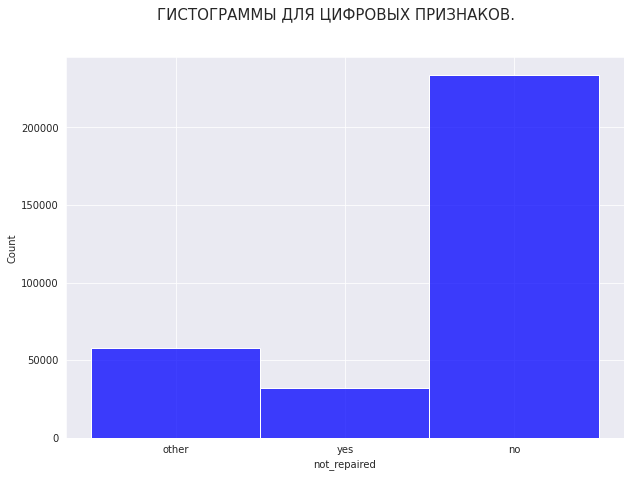

In [47]:
plt.figure(figsize=[10, 7])
plt.suptitle('ГИСТОГРАММЫ ДЛЯ ЦИФРОВЫХ ПРИЗНАКОВ.', fontsize=15)
sns.set_style('darkgrid')
sns.histplot(data['not_repaired'], color='b', kde=False);

**Заполним отсутствующние значения - No**

In [48]:
data['not_repaired'] = data['not_repaired'].replace('other','no')

**Рассмотрим колонку "Тип машины"**

In [49]:
data['vehicle_type'].unique()

array([nan, 'coupe', 'suv', 'small', 'sedan', 'convertible', 'bus',
       'wagon', 'other'], dtype=object)

**В колонке есть пропуски, заменим их часто повторяющимся значением основанным на группировке по брендку и модели.**

In [50]:
data['vehicle_type'] = data.groupby(['brand', 'model'])['vehicle_type'].transform(lambda x: x.fillna((x.mode()[0] if not x.mode().empty else 'other')))

In [51]:
print('Количество строк с типо машины - other -', len(data[data['vehicle_type'] == 'other']))

Количество строк с типо машины - other - 2851


**Так как таких строк не много, удалим их**

In [52]:
data = data[data['vehicle_type'] != 'other']

**Рассмотрим колонку gearbox**

In [53]:
data['gearbox'].unique()

array(['manual', 'auto', nan], dtype=object)

**Пропуски заменим часто повторяющимся значением основанным на группировке по бренду и модели. Если оставшихся неопределенных значений будет не много, удалим их**

In [54]:
data['gearbox'] = data.groupby(['brand', 'model'])['gearbox'].transform(lambda x: x.fillna((x.mode()[0] if not x.mode().empty else 'other')))

In [55]:
print('Количество строк с типом коробки other -', len(data[data['gearbox'] == 'other']))

Количество строк с типом коробки other - 0


**Рассмотрим распределение значений в колонках с цифровыми значениями.**

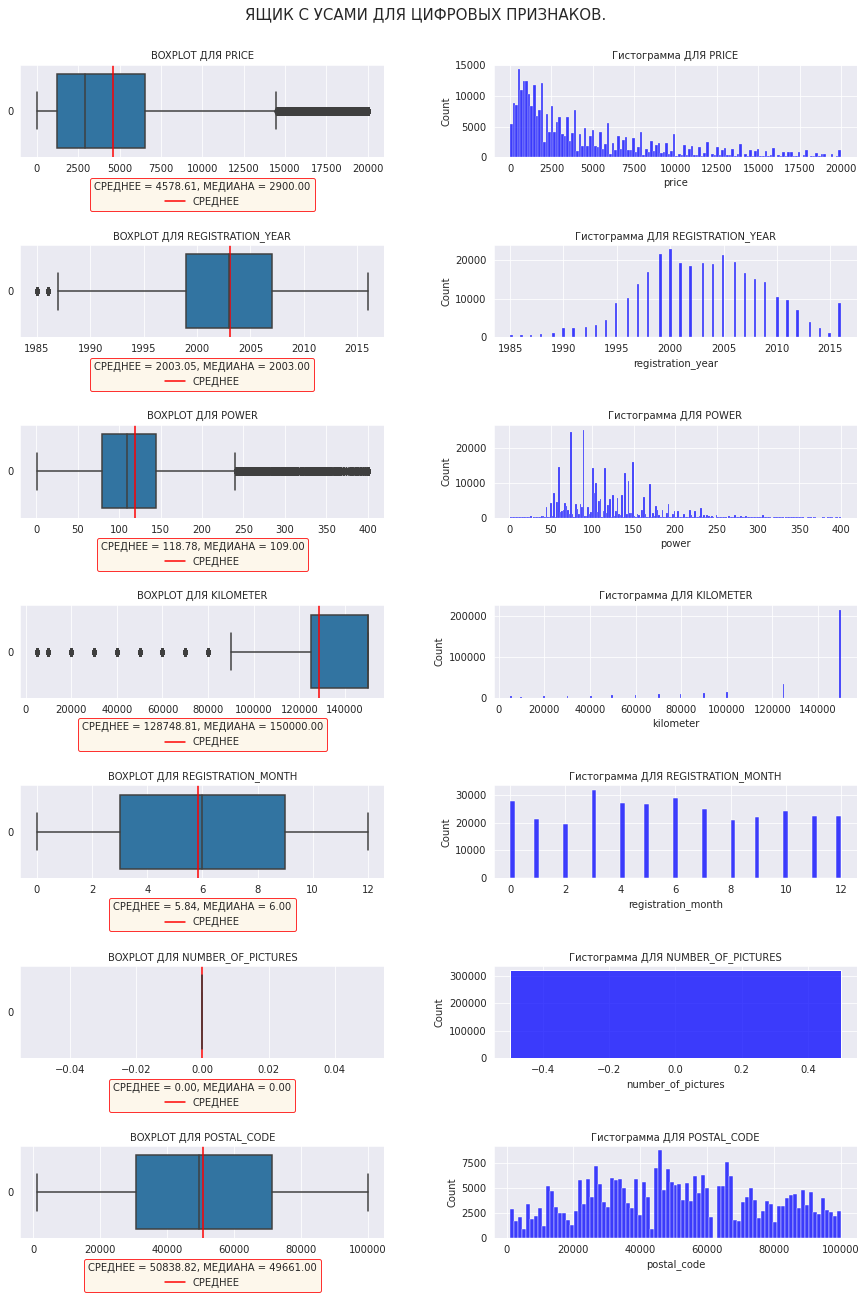

In [56]:
position = 0
num_region = None
plt.figure(figsize=[15, 20])
plt.subplots_adjust(top=0.94, wspace=0.3, hspace=0.95)
plt.suptitle('ЯЩИК С УСАМИ ДЛЯ ЦИФРОВЫХ ПРИЗНАКОВ.', fontsize=15)

number = len(data.loc[:, data.dtypes == np.int64].dtypes.index)
columns_witn_int = data.loc[:, data.dtypes == np.int64].dtypes.index
for column_name in columns_witn_int:
    position += 1
    plt.subplot(number, 2, position)
    plt.title(f'BOXPLOT ДЛЯ {column_name.upper()}', fontsize=10)
    sns.set_style('darkgrid')
    sns.boxplot(data=data[column_name], orient='h')
    plt.axvline(np.mean(data[column_name]), 
               color='r', 
               linestyle='-',
               label='СРЕДНЕЕ')
    plt.legend(title=f'СРЕДНЕЕ = {np.mean(data[column_name]):.2f}, МЕДИАНА = {np.median(data[column_name]):.2f}', 
               loc='center', 
               edgecolor = 'r',
               facecolor = 'oldlace',
               bbox_to_anchor=(0.5, -0.40))
    position += 1
    plt.subplot(number, 2, position)
    sns.set_style('darkgrid')
    plt.title(f'Гистограмма ДЛЯ {column_name.upper()}', fontsize=10)
    sns.histplot(data=data[column_name], color='b', kde=False)
plt.show();

**В данных присутствуют аномалии и разброс.**

In [57]:
if (data.duplicated().sum()) > 0:
    print('Количество обнаруженных явных дубликатов -', data.duplicated().sum())
    data = data.drop_duplicates().reset_index(drop=True)
    print('Количество явных дубликтов после удаления -',data.duplicated().sum())
    

Количество обнаруженных явных дубликатов - 1
Количество явных дубликтов после удаления - 0


In [58]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 321196 entries, 0 to 321195
Data columns (total 16 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   date_crawled        321196 non-null  datetime64[ns]
 1   price               321196 non-null  int64         
 2   vehicle_type        321196 non-null  object        
 3   registration_year   321196 non-null  int64         
 4   gearbox             321196 non-null  object        
 5   power               321196 non-null  int64         
 6   model               321196 non-null  object        
 7   kilometer           321196 non-null  int64         
 8   registration_month  321196 non-null  int64         
 9   fuel_type           321196 non-null  object        
 10  brand               321196 non-null  object        
 11  not_repaired        321196 non-null  object        
 12  date_created        321196 non-null  datetime64[ns]
 13  number_of_pictures  321196 no

### Вывод

**В данных:**

- **Регистр названиий колонок не соответствовал snake_case**

- **Присутствовали пропуски**

- **Обнаружены аномальные значения**

## Обучение моделей

**Посмотрим на корреляцию значений.**

**Избавимся от колонок, содержимое которых может негативно повлиять на дальнейшее обучение моделей.**

In [59]:
data.corr()

,price,registration_year,power,kilometer,registration_month,number_of_pictures,postal_code
price,1.000000,0.566843,0.512123,-0.362372,0.095248,NaN,0.071039
registration_year,0.566843,1.000000,0.130927,-0.349040,0.051100,NaN,0.035308
power,0.512123,0.130927,1.000000,0.099179,0.055423,NaN,0.060425
kilometer,-0.362372,-0.349040,0.099179,1.000000,-0.005394,NaN,-0.010531
registration_month,0.095248,0.051100,0.055423,-0.005394,1.000000,NaN,0.008297
number_of_pictures,NaN,NaN,NaN,NaN,NaN,NaN,NaN
postal_code,0.071039,0.035308,0.060425,-0.010531,0.008297,NaN,1.000000


**Для postal_code корреляция слабая. У месяца регистрации значение близкое к 0.1, считаю нужным оставить.**

In [60]:
data = data.drop(['date_crawled', 'date_created', 'number_of_pictures', 'postal_code', 'last_seen', 'registration_month'], axis=1)

In [61]:
data = data.astype({"vehicle_type":'category', 
                    "gearbox":'category', 
                    "model":'category', 
                    "fuel_type":'category', 
                    "brand":'category', 
                    "not_repaired":'category'})

In [62]:
dct_with_params = {}

**Далее подберу лучшие параметры и обучу по ним модель.**

### Модель DecisionTreeRegressor

In [63]:
state = RandomState(12345)

In [64]:
features = data.drop('price', axis=1)
target = data['price']

In [65]:
ft_train_le, ft_test_le, tr_train_le, tr_test_le = train_test_split(features, target, test_size=0.25, random_state=12345)

In [66]:
text_columns = ['vehicle_type', 'gearbox', 'model', 'fuel_type', 'brand', 'not_repaired']
label_encode = LabelEncoder()
for column in text_columns:
    ft_train_le[column] = label_encode.fit_transform(ft_train_le[column].astype('str'))
    ft_test_le[column] = label_encode.fit_transform(ft_test_le[column].astype('str'))

/tmp/ipykernel_36/2174029615.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ft_train_le[column] = label_encode.fit_transform(ft_train_le[column].astype('str'))
/tmp/ipykernel_36/2174029615.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ft_test_le[column] = label_encode.fit_transform(ft_test_le[column].astype('str'))


In [67]:
del label_encode

In [68]:
del data

In [ ]:
# %%time
# best_rmse_for_dt = None
# for n in range(1, 20, 1):
#     model_dt = DecisionTreeRegressor(max_depth=n, random_state=state)
#     dt_score = cross_val_score(model_dt, 
#                                features_train,
#                                target_train,
#                                scoring=rmse_score,
#                                cv=5)
#     dt_score_final = dt_score.mean()*(-1)
# #     print(dt_score_final, n)
#     if best_rmse_for_dt is None:
#         best_rmse_for_dt = dt_score_final
#         dct_with_params['DT'] = {'max_depth': n}
#     if dt_score_final < best_rmse_for_dt:
#         best_rmse_for_dt = dt_score_final
#         dct_with_params['DT'] = {'max_depth': n, 'RMSE': best_rmse_for_dt}

In [70]:
%%time
start_time = time.time()
decision_tree = DecisionTreeRegressor()
distributions = dict(max_depth=np.arange(1,10,1), splitter=['best', 'random'])
dtr = RandomizedSearchCV(decision_tree, distributions, scoring='neg_mean_squared_error',  random_state=state)
dtr.fit(ft_train_le, tr_train_le)
end_time = time.time()
sh_time = (end_time - start_time) / 60
score_rmse = (-dtr.best_score_) ** 0.5
dct_with_params['DT'] = dtr.best_params_
dct_with_params['DT'].update(train_rmse=score_rmse,search_time=sh_time)

CPU times: user 8.5 s, sys: 11.8 ms, total: 8.51 s
Wall time: 8.53 s


In [71]:
del dtr

In [72]:
del decision_tree

In [73]:
%%time
test_model_dt = DecisionTreeRegressor(max_depth=dct_with_params['DT']['max_depth'], random_state=state)
start_time = time.time()
test_model_dt.fit(ft_train_le, tr_train_le)
end_time = time.time()
tr_time = (end_time - start_time) / 60

CPU times: user 535 ms, sys: 18 µs, total: 535 ms
Wall time: 540 ms


In [74]:
dct_with_params['DT'].update(train_time=tr_time)

### Модель RandomForestRegressor

In [ ]:
# %%time
# best_rmse_for_rf = None
# for n in [10,50]:
#     for d in range(2,10,2):
#         model_rf = RandomForestRegressor(n_estimators=n, max_depth=d, random_state=state)
#         rf_score = cross_val_score(model_rf, 
#                                    features_train,
#                                    target_train,
#                                    scoring=rmse_score,
#                                    cv=5)
#         rf_score_final = rf_score.mean()*(-1)
#         print(rf_score_final, n, d)
#         if best_rmse_for_rf is None:
#             best_rmse_for_rf = rf_score_final
#             dct_with_params['RF'] = {'n_estimators':n ,'max_depth': d}
#         if rf_score_final < best_rmse_for_rf:
#             best_rmse_for_rf = rf_score_final
#             dct_with_params['RF'] = {'n_estimators':n ,'max_depth': d, 'RMSE': best_rmse_for_rf}

In [75]:
%%time
start_time = time.time()
random_forest = RandomForestRegressor()
distributions = dict(max_depth=[10,50], n_estimators=np.arange(2,10,2), n_jobs=[1,-1])
rfr = RandomizedSearchCV(random_forest, distributions, scoring='neg_mean_squared_error',  random_state=state)
rfr.fit(ft_train_le, tr_train_le)
end_time = time.time()
sh_time = (end_time - start_time) / 60
score_rmse = (-rfr.best_score_) ** 0.5
dct_with_params['RF'] = rfr.best_params_
dct_with_params['RF'].update(train_rmse=score_rmse,search_time=sh_time)

CPU times: user 1min 53s, sys: 659 ms, total: 1min 53s
Wall time: 1min 54s


In [76]:
%%time
test_model_rf = RandomForestRegressor(n_estimators=dct_with_params['RF']['n_estimators'],
                                      max_depth=dct_with_params['RF']['max_depth'],
                                      random_state=state)
start_time = time.time()
test_model_rf.fit(ft_train_le, tr_train_le)
end_time = time.time()
tr_time = (end_time - start_time) / 60

CPU times: user 5.68 s, sys: 72 ms, total: 5.76 s
Wall time: 5.77 s


In [77]:
del rfr

In [78]:
del random_forest

In [79]:
del ft_train_le

In [80]:
del tr_train_le

In [81]:
dct_with_params['RF'].update(train_time=tr_time)

### CatBoostRegressor 

In [82]:
ft_train_original, ft_test_original, tr_train_original, tr_test_original = train_test_split(features, target, test_size=0.25, random_state=12345)

In [83]:
del features

In [84]:
del target

In [85]:
%%time
start_time = time.time()
train_pool = Pool(ft_train_original, tr_train_original, cat_features=text_columns)
cat = CatBoostRegressor(loss_function="RMSE", verbose=False)

params = {"depth": [5,10]}

grid_search_results = cat.grid_search(params, train_pool, cv=2, verbose=False,  plot=False)
end_time = time.time()
sh_time = (end_time - start_time) / 60


bestTest = 1694.70537
bestIteration = 999


bestTest = 1579.364346
bestIteration = 999

Training on fold [0/2]

bestTest = 1590.416923
bestIteration = 999

Training on fold [1/2]

bestTest = 1598.372366
bestIteration = 999

CPU times: user 26min 47s, sys: 12.5 s, total: 26min 59s
Wall time: 27min 13s


In [86]:
dct_with_params['CBR'] = grid_search_results['params']
dct_with_params['CBR'].update(search_time=sh_time)

In [87]:
%%time
test_cat = CatBoostRegressor(depth=dct_with_params['CBR']['depth'], 
                              loss_function='RMSE',verbose=False)
start_time = time.time()                              
test_cat.fit(train_pool)
end_time = time.time()
tr_time = (end_time - start_time) / 60

CPU times: user 6min 52s, sys: 1.24 s, total: 6min 53s
Wall time: 7min


In [88]:
del train_pool

In [89]:
dct_with_params['CBR'].update(train_time=tr_time)
dct_with_params['CBR'].update(train_rmse=test_cat.get_best_score()['learn']['RMSE'])

### Модель LightGBM

In [103]:
%%time
lgb_model = lgb.LGBMRegressor()
lgb_train = lgb.Dataset(ft_train_original,
                        tr_train_original,
                        categorical_feature=['vehicle_type', 'gearbox', 'model', 'fuel_type', 'brand', 'not_repaired'],
                        free_raw_data=False)
lgb_test = lgb.Dataset(ft_test_original,
                       tr_test_original,
                       categorical_feature=['vehicle_type', 'gearbox', 'model', 'fuel_type', 'brand', 'not_repaired'],
                       free_raw_data=False)
start_time = time.time()

distributions = {'max_depth': [5,10,15,20], 'learning_rate': [0.1, 0.2], 'n_jobs': [1,-1]}
lgb_search = RandomizedSearchCV(lgb_model, distributions, scoring='neg_mean_squared_error',  random_state=state)
lgb_search.fit(ft_train_original, tr_train_original)

score_rmse = (-lgb_search.best_score_) ** 0.5
end_time = time.time()
sh_time = (end_time - start_time) / 60

CPU times: user 1min 15s, sys: 355 ms, total: 1min 15s
Wall time: 1min 17s


In [104]:
dct_with_params['LGB'] = lgb_search.best_params_
dct_with_params['LGB'].update(search_time=sh_time, train_rmse=score_rmse)

In [107]:
%%time
param = {'metric': 'rmse', 'max_depth':dct_with_params['LGB']['max_depth'], "random_state": 12345, "learning_rate":dct_with_params['LGB']['learning_rate'], 'n_jobs': dct_with_params['LGB']['n_jobs']}
star_time = time.time()
test_model_lgb = lgb.train(param,  
                           lgb_train,
                           valid_sets=[lgb_test],
                           categorical_feature=['vehicle_type', 'gearbox', 'model', 'fuel_type', 'brand', 'not_repaired'],
                           num_boost_round=1000)
end_time = time.time()
tr_time = (end_time - start_time) / 60

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011432 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 557
[LightGBM] [Info] Number of data points in the train set: 240897, number of used feature

In [108]:
del ft_train_original

In [109]:
del tr_train_original

In [110]:
dct_with_params['LGB'].update(train_time=tr_time)

### Вывод

In [111]:
model = []
train_time = []
search_time = []
train_rmse = []

In [112]:
for k in dct_with_params.keys():
    model.append(k)
    search_time.append(dct_with_params[k]['search_time'])
    train_time.append(dct_with_params[k]['train_time'])
    train_rmse.append(dct_with_params[k]['train_rmse'])


In [113]:
results = {
    'Model' : model,
    'Train RMSE' :pd.Series(train_rmse),
    'Search Time (min)': pd.Series(search_time),
    'Train Time (min)': pd.Series(train_time),

    }
display(pd.DataFrame(results))

,Model,Train RMSE,Search Time (min),Train Time (min)
0,DT,2051.218323,0.142094,0.009005
1,RF,1652.243192,1.912049,0.096083
2,CBR,1360.442109,27.231136,7.005172
3,LGB,1592.048679,1.288735,3.447391


**Быстрее всех обучается модель "Дерево Решений", дольше всех "CatBoostRegressor". Лучший результат метрики при обучении у CatBoostRegressor.**

## Анализ моделей

### Протестируем модели

In [114]:
%%time
start = time.time()
dt_rmse = mean_squared_error(tr_test_le,test_model_dt.predict(ft_test_le),squared=False)
end = time.time()
test_time = (end - start) / 60

CPU times: user 14.4 ms, sys: 15 µs, total: 14.5 ms
Wall time: 13.4 ms


In [115]:
dct_with_params['DT'].update(test_rmse=dt_rmse,test_time=test_time)

In [116]:
%%time
start = time.time()
rf_rmse = mean_squared_error(tr_test_le,test_model_rf.predict(ft_test_le),squared=False)
end = time.time()
test_time = (end - start) / 60

CPU times: user 270 ms, sys: 0 ns, total: 270 ms
Wall time: 269 ms


In [117]:
dct_with_params['RF'].update(test_rmse=rf_rmse, test_time=test_time)

In [118]:
%%time
start = time.time()
cbr_rmse = mean_squared_error(tr_test_original,test_cat.predict(ft_test_original),squared=False)
end = time.time()
test_time = (end - start) / 60

CPU times: user 1.78 s, sys: 0 ns, total: 1.78 s
Wall time: 1.78 s


In [119]:
dct_with_params['CBR'].update(test_rmse=cbr_rmse, test_time=test_time)

In [120]:
%%time
start = time.time()
lgb_rmse = mean_squared_error(tr_test_original,test_model_lgb.predict(ft_test_original),squared=False)
end = time.time()
test_time = (end - start) / 60

CPU times: user 6.25 s, sys: 0 ns, total: 6.25 s
Wall time: 6.26 s


In [121]:
dct_with_params['LGB'].update(test_rmse=lgb_rmse, test_time=test_time)

In [122]:
test_time = []
rmse_test = []
for k in dct_with_params.keys():
    rmse_test.append(dct_with_params[k]['test_rmse'])
    test_time.append(dct_with_params[k]['test_time'])

In [123]:
results = {
    'Model' : model,
    'Train RMSE' :pd.Series(train_rmse),
    'Test RMSE' :pd.Series(rmse_test),
    'Search Time (min)': pd.Series(search_time),
    'Train Time (min)': pd.Series(train_time),
    'Test Time (min)': pd.Series(test_time)
    }
display(pd.DataFrame(results))

,Model,Train RMSE,Test RMSE,Search Time (min),Train Time (min),Test Time (min)
0,DT,2051.218323,2051.099571,0.142094,0.009005,0.000223
1,RF,1652.243192,1638.224845,1.912049,0.096083,0.004483
2,CBR,1360.442109,1535.049282,27.231136,7.005172,0.029711
3,LGB,1592.048679,1527.629823,1.288735,3.447391,0.104339


### Вывод

**Быстрее всех работает модель дерево решений, дольше - LightGBM и CatBoostRegressor . Лучший результат у LightGBM и CatBoostRegressor.**

## Вывод

**Дольше всех обучались и подбирались параметры у  моделей LightGBM и CatBoostRegressor.**

**Быстрее всего работает модель "Дерево решений",  лучший результат не смотря на время работы у модели "LightGBM".**

**Не смотря на длительное по сравнению с другими моделями время работы у модели "CatBoostRegressor", она превосходит остальные по качеству предсказания, хоть и не. значительно уступает по качеству LightGBM, но превосходит ее по времени работы.**

**Считаю, что она является наиболее предпочтительной моделью. В дополнение: у отличная документация, удобство исползования и гибкая система настройки параметров.**